In [1]:
#한글
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122518 files and dir

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Patch
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic')

In [3]:
#이거는 시계열 훈련셋나눈거 시각화할려고 해둔거니까 무시하세요
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')
def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

#SVM

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
#full모델, 변수선택한 모델 용으로 각각 list만들었습니다.
full_list = ['종가', '대비', '등락률', '거래량', '거래대금', '시가총액',
       '외국인 보유수량', '외국인 지분율', '토론방', '순매수_기관', '순매수_기타법인', '순매수_개인', '순매수_외국인',
       '검색어', '보도량', '기사감성점수', '뉴스심리지수', '비트코인종가', '비트코인거래량', '비트코인변동',
       '코스피종가', '코스피대비', '코스피등락률', '코스피거래량', '코스피거래대금', '코스피시가총액', '한은금리',
       '원/미국달러', '원/위안', '원/일본엔(100엔)', '원/유로', '경제심리지수(원계열)', '경제심리지수(순환변동치)',
       '산업생산지수', '물가상승률', '소비자신뢰지수', '소비자심리지수', '경제활동참가율(%)', '실업률(%)',
       '고용률(%)']
cor_list=['등락률','종가','거래량','거래대금','시가총액','토론방','순매수_기관','순매수_기타법인','순매수_개인','순매수_외국인','검색어','보도량','기사감성점수','코스피등락률','코스피거래대금']
vif_list=['경제심리지수(순환변동치)','시가총액','비트코인종가','원/미국달러','소비자심리지수','코스피거래대금','순매수_개인',
         '순매수_외국인','산업생산지수','코스피거래량','뉴스심리지수','원/유로','토론방','실업률(%)','원/일본엔(100엔)',
    '거래량','기사감성점수','외국인 보유수량','코스피등락률','경제활동참가율(%)','검색어','보도량','순매수_기관',
    '비트코인거래량','비트코인변동']


##하이닉스

In [ ]:
!pip install optuna

In [53]:
sk_label=pd.read_csv('/content/drive/MyDrive/2023-1학기-시계열팀주제분석/PreprocessedData/labeled/SK_label(5일추가).csv')

In [54]:
#5일 예측
#내일 5일 등락률 df만들기
sk=sk_label.drop(['year','month','day','3일 등락률','day1_label','day3_label','5일 등락률','day5_label'],axis=1)
sk1=sk.shift(1) #한 행씩 데이터 아래로 내리기
df=pd.concat([sk1,pd.DataFrame(sk_label['day5_label'])],axis=1) #하루 전 데이터로 y변수 예측
df=df.drop(0,axis=0)
df=df.reset_index(drop=True)

In [55]:
#변수 설정
x=df[vif_list]
y=df['day5_label']

In [56]:
#x 스케일링
ss = MinMaxScaler()
scaled_x=ss.fit(x).transform(x)
scaled_x=pd.DataFrame(scaled_x)
scaled_x.columns = x.columns

In [12]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)

def objective(trial):
    params = {
        'C': trial.suggest_int('C', 1, 30),
        'degree': trial.suggest_int('degree', 2, 10),
    }

    scores = []
    for i, (train_index, test_index) in enumerate(tscv.split(x)):
        x_train, y_train=scaled_x.iloc[train_index], y.iloc[train_index]
        x_test, y_test=scaled_x.iloc[test_index], y.iloc[test_index]

        svm_model=SVC(**params,kernel='poly')
        svm_model.fit(x_train, y_train)

        y_pred=svm_model.predict(x_test)
        score = f1_score(y_test, y_pred, average='weighted')
        scores.append(score)

    return sum(scores) / len(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f'Best trial: score={study.best_value:.5f}, params={study.best_params}')

[I 2023-05-09 08:29:42,941] A new study created in memory with name: no-name-5a0831c9-edf7-482d-a4a3-9f3f579dd3fd
[I 2023-05-09 08:29:43,455] Trial 0 finished with value: 0.5726076464314882 and parameters: {'C': 10, 'degree': 2}. Best is trial 0 with value: 0.5726076464314882.
[I 2023-05-09 08:29:44,123] Trial 1 finished with value: 0.4758467677036174 and parameters: {'C': 29, 'degree': 3}. Best is trial 0 with value: 0.5726076464314882.
[I 2023-05-09 08:29:45,011] Trial 2 finished with value: 0.4989191869977536 and parameters: {'C': 18, 'degree': 4}. Best is trial 0 with value: 0.5726076464314882.
[I 2023-05-09 08:29:45,238] Trial 3 finished with value: 0.5287442606507733 and parameters: {'C': 18, 'degree': 2}. Best is trial 0 with value: 0.5726076464314882.
[I 2023-05-09 08:29:46,239] Trial 4 finished with value: 0.33979808324944194 and parameters: {'C': 3, 'degree': 10}. Best is trial 0 with value: 0.5726076464314882.
[I 2023-05-09 08:29:46,540] Trial 5 finished with value: 0.474776

Best trial: score=0.64473, params={'C': 2, 'degree': 2}


In [59]:
#엔코딩으로 진행
tscv=TimeSeriesSplit(n_splits=4)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    x_train, y_train=scaled_x.iloc[train_index],y.iloc[train_index]
    x_test, y_test=scaled_x.iloc[test_index],y.iloc[test_index]
    
    svm_model = SVC(kernel='poly',C=20,degree=2)
    svm_model.fit(x_train, y_train)

    y_pred = svm_model.predict(x_test)
    print(f"Fold {i+1} - f1_score: {f1_score(y_test, y_pred,average='weighted')}")

Fold 1 - f1_score: 0.4677967165057972
Fold 2 - f1_score: 0.6309655055935903
Fold 3 - f1_score: 0.27967331841080223
Fold 4 - f1_score: 0.6961332662787729


In [60]:
cm = confusion_matrix(y_test, y_pred)
print('매수 정확도 : ',cm[0,0]/sum(cm[0]))
print('매도 정확도 : ',cm[2,2]/sum(cm[2]))
print('유지 정확도 : ',cm[1,1]/sum(cm[1]))
print(cm)

매수 정확도 :  0.2972972972972973
매도 정확도 :  0.32608695652173914
유지 정확도 :  0.8888888888888888
[[ 11  25   1]
 [ 11 176  11]
 [  5  26  15]]


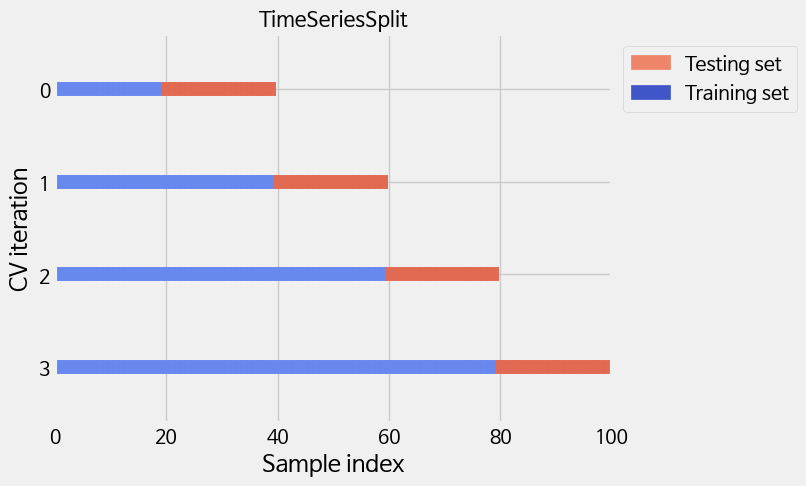

In [ ]:
plot_cv_indices(tscv,np.arange(100),n_splits=4)

##신한

In [61]:
shinhan_label=pd.read_csv('/content/drive/MyDrive/2023-1학기-시계열팀주제분석/PreprocessedData/labeled/shinhan_label(5일추가).csv')

In [62]:
shinhan_label.columns

Index(['날짜', 'year', 'month', 'day', '종가', '대비', '등락률', '거래량', '거래대금', '시가총액',
       '외국인 보유수량', '외국인 지분율', '토론방', '순매수_기관', '순매수_기타법인', '순매수_개인', '순매수_외국인',
       '검색어', '보도량', '기사감성점수', '뉴스심리지수', '비트코인종가', '비트코인거래량', '비트코인변동',
       '코스피종가', '코스피대비', '코스피등락률', '코스피거래량', '코스피거래대금', '코스피시가총액', '한은금리',
       '원/미국달러', '원/위안', '원/일본엔(100엔)', '원/유로', '경제심리지수(원계열)', '경제심리지수(순환변동치)',
       '산업생산지수', '물가상승률', '소비자신뢰지수', '소비자심리지수', '경제활동참가율(%)', '실업률(%)',
       '고용률(%)', 'year-month', '5일 등락률', 'day5_label'],
      dtype='object')

In [63]:
#5일 예측
#내일 5일 등락률 df만들기
shinhan=shinhan_label.drop(['year','month','day','5일 등락률','day5_label'],axis=1)
shinhan1=shinhan.shift(1) #한 행씩 데이터 아래로 내리기
df=pd.concat([shinhan1,pd.DataFrame(shinhan_label['day5_label'])],axis=1) #하루 전 데이터로 y변수 예측
df=df.drop(0,axis=0)
df=df.reset_index(drop=True)

In [66]:
#변수 설정
x=df[vif_list]
y=df['day5_label']

In [67]:
#x 스케일링
ss = MinMaxScaler()
scaled_x=ss.fit(x).transform(x)
scaled_x=pd.DataFrame(scaled_x)
scaled_x.columns = x.columns

In [68]:
#엔코딩으로 진행
tscv=TimeSeriesSplit(n_splits=4)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    x_train, y_train=scaled_x.iloc[train_index],y.iloc[train_index]
    x_test, y_test=scaled_x.iloc[test_index],y.iloc[test_index]
    
    svm_model = SVC(kernel='poly',C=20,degree=2)
    svm_model.fit(x_train, y_train)

    y_pred = svm_model.predict(x_test)
    print(f"Fold {i+1} - f1_score: {f1_score(y_test, y_pred,average='weighted')}")

Fold 1 - f1_score: 0.8755349913244649
Fold 2 - f1_score: 0.7256033832142154
Fold 3 - f1_score: 0.8676179872207678
Fold 4 - f1_score: 0.7167660381546159


In [69]:
cm = confusion_matrix(y_test, y_pred)
print('매수 정확도 : ',cm[0,0]/sum(cm[0]))
print('매도 정확도 : ',cm[2,2]/sum(cm[2]))
print('유지 정확도 : ',cm[1,1]/sum(cm[1]))
print(cm)

매수 정확도 :  0.42105263157894735
매도 정확도 :  0.0
유지 정확도 :  0.8166666666666667
[[  8  11   0]
 [ 44 196   0]
 [  3  23   0]]


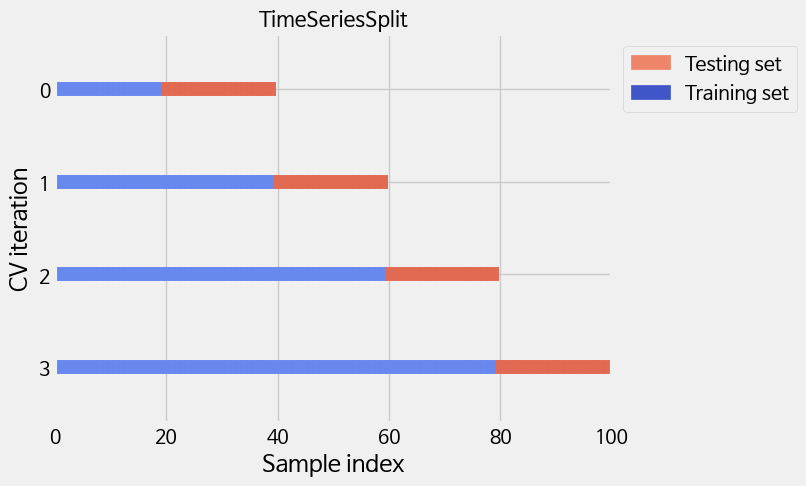

In [80]:
plot_cv_indices(tscv,np.arange(100),n_splits=4)

##현대차

In [70]:
hd_label=pd.read_csv('/content/drive/MyDrive/2023-1학기-시계열팀주제분석/PreprocessedData/labeled/hd_label(5일추가).csv')

In [71]:
#5일 예측
#내일 5일 등락률 df만들기
hd=hd_label.drop(['year','month','day','5일 등락률','day5_label'],axis=1)
hd1=hd.shift(1) #한 행씩 데이터 아래로 내리기
df=pd.concat([hd1,pd.DataFrame(hd_label['day5_label'])],axis=1) #하루 전 데이터로 y변수 예측
df=df.drop(0,axis=0)
df=df.reset_index(drop=True)

In [74]:
#변수 설정
x=df[vif_list]
y=df['day5_label']

In [75]:
#x 스케일링
ss = MinMaxScaler()
scaled_x=ss.fit(x).transform(x)
scaled_x=pd.DataFrame(scaled_x)
scaled_x.columns = x.columns

In [78]:
#엔코딩으로 진행
tscv=TimeSeriesSplit(n_splits=4)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    x_train, y_train=scaled_x.iloc[train_index],y.iloc[train_index]
    x_test, y_test=scaled_x.iloc[test_index],y.iloc[test_index]
    
    svm_model = SVC(kernel='poly',C=20,degree=2)
    svm_model.fit(x_train, y_train)

    y_pred = svm_model.predict(x_test)
    print(f"Fold {i+1} - f1_score: {f1_score(y_test, y_pred,average='weighted')}")

Fold 1 - f1_score: 0.8280878736087375
Fold 2 - f1_score: 0.6116895303632871
Fold 3 - f1_score: 0.8599033816425121
Fold 4 - f1_score: 0.8778348899403874


In [79]:
cm = confusion_matrix(y_test, y_pred)
print('매수 정확도 : ',cm[0,0]/sum(cm[0]))
print('매도 정확도 : ',cm[2,2]/sum(cm[2]))
print('유지 정확도 : ',cm[1,1]/sum(cm[1]))
print(cm)

매수 정확도 :  0.0
매도 정확도 :  0.3333333333333333
유지 정확도 :  0.8881578947368421
[[  0   3   0]
 [  6 135  11]
 [  1   3   2]]


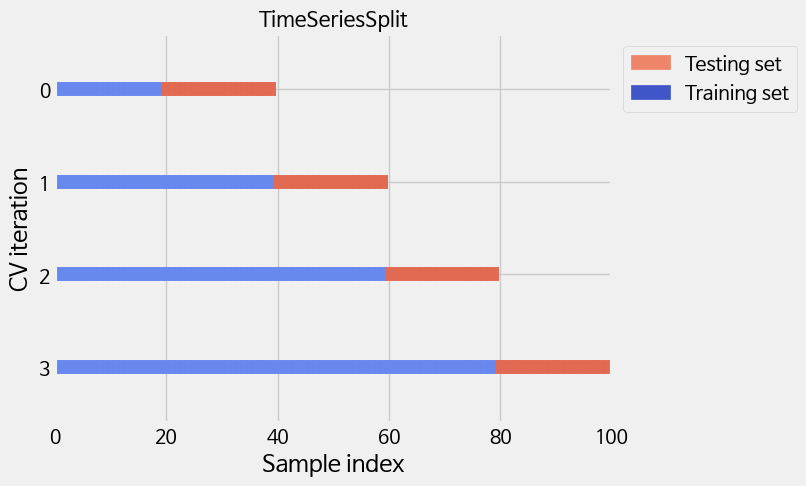

In [81]:
plot_cv_indices(tscv,np.arange(100),n_splits=4)

#로지스틱 (버림)

In [82]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [83]:
#full모델, 변수선택한 모델 용으로 각각 list만들었습니다.
full_list = ['종가', '대비', '등락률', '거래량', '거래대금', '시가총액',
       '외국인 보유수량', '외국인 지분율', '토론방', '순매수_기관', '순매수_기타법인', '순매수_개인', '순매수_외국인',
       '검색어', '보도량', '기사감성점수', '뉴스심리지수', '비트코인종가', '비트코인거래량', '비트코인변동',
       '코스피종가', '코스피대비', '코스피등락률', '코스피거래량', '코스피거래대금', '코스피시가총액', '한은금리',
       '원/미국달러', '원/위안', '원/일본엔(100엔)', '원/유로', '경제심리지수(원계열)', '경제심리지수(순환변동치)',
       '산업생산지수', '물가상승률', '소비자신뢰지수', '소비자심리지수', '경제활동참가율(%)', '실업률(%)',
       '고용률(%)']
cor_list=['등락률','토론방','순매수_기관','순매수_기타법인','순매수_개인','순매수_외국인','기사감성점수','코스피등락률','대비'] #1일치
cor_list3=['등락률','종가','거래량','거래대금','시가총액','토론방','순매수_기관','순매수_기타법인','순매수_개인','순매수_외국인','검색어','보도량','기사감성점수','코스피등락률','코스피거래대금'] #3일치
vif_list=['경제심리지수(순환변동치)','시가총액','비트코인종가','원/미국달러','소비자심리지수','코스피거래대금','순매수_개인',
         '순매수_외국인','산업생산지수','코스피거래량','뉴스심리지수','원/유로','토론방','실업률(%)','원/일본엔(100엔)',
    '거래량','기사감성점수','외국인 보유수량','코스피등락률','경제활동참가율(%)','검색어','보도량','순매수_기관',
    '비트코인거래량','비트코인변동']

##하이닉스

In [84]:
sk_label=pd.read_csv('/content/drive/MyDrive/2023-1학기-시계열팀주제분석/PreprocessedData/labeled/SK_label(5일추가).csv')

In [85]:
sk=sk_label.drop(['year','month','day','3일 등락률','day1_label','day3_label','5일 등락률','day5_label'],axis=1)
sk1=sk.shift(1) #한 행씩 데이터 아래로 내리기
df=pd.concat([sk1,pd.DataFrame(sk_label['day5_label'])],axis=1) #하루 전 데이터로 y변수 예측
df=df.drop(0,axis=0)
df=df.reset_index(drop=True)

In [86]:
x=df[full_list]
y=df['day5_label']
#x 스케일링
ss = MinMaxScaler()
scaled_x=ss.fit(x).transform(x)
scaled_x=pd.DataFrame(scaled_x)
scaled_x.columns = x.columns

In [87]:
tscv=TimeSeriesSplit(n_splits=4)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    x_train, y_train=scaled_x.iloc[train_index],y.iloc[train_index]
    x_test, y_test=scaled_x.iloc[test_index],y.iloc[test_index]
    lr = LogisticRegression(C=8,max_iter=5000,class_weight='balanced',solver='lbfgs')
    lr_model = lr.fit(x_train,y_train)

    y_pred = lr_model.predict(x_test)
    print(f"Fold {i+1} - f1_score: {f1_score(y_test, y_pred,average='weighted')}")

Fold 1 - f1_score: 0.5026301655824141
Fold 2 - f1_score: 0.5293942635257449
Fold 3 - f1_score: 0.4671478799592678
Fold 4 - f1_score: 0.1242906671270096


In [88]:
cm = confusion_matrix(y_test, y_pred)
print('매수 정확도 : ',cm[0,0]/sum(cm[0]))
print('매도 정확도 : ',cm[2,2]/sum(cm[2]))
print('유지 정확도 : ',cm[1,1]/sum(cm[1]))
print(cm)

매수 정확도 :  0.05405405405405406
매도 정확도 :  0.9347826086956522
유지 정확도 :  0.050505050505050504
[[  2   2  33]
 [  5  10 183]
 [  0   3  43]]


##신한

In [89]:
shinhan_label=pd.read_csv('/content/drive/MyDrive/2023-1학기-시계열팀주제분석/PreprocessedData/labeled/shinhan_label(5일추가).csv')

In [91]:
shinhan=shinhan_label.drop(['year','month','day','5일 등락률','day5_label'],axis=1)
shinhan1=shinhan.shift(1) #한 행씩 데이터 아래로 내리기
df=pd.concat([shinhan1,pd.DataFrame(shinhan_label['day5_label'])],axis=1) #하루 전 데이터로 y변수 예측
df=df.drop(0,axis=0)
df=df.reset_index(drop=True)

In [92]:
x=df[full_list]
y=df['day5_label']
#x 스케일링
ss = MinMaxScaler()
scaled_x=ss.fit(x).transform(x)
scaled_x=pd.DataFrame(scaled_x)
scaled_x.columns = x.columns

In [93]:
tscv=TimeSeriesSplit(n_splits=4)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    x_train, y_train=scaled_x.iloc[train_index],y.iloc[train_index]
    x_test, y_test=scaled_x.iloc[test_index],y.iloc[test_index]
    lr = LogisticRegression(C=8,max_iter=5000,class_weight='balanced',solver='lbfgs')
    lr_model = lr.fit(x_train,y_train)

    y_pred = lr_model.predict(x_test)
    print(f"Fold {i+1} - f1_score: {f1_score(y_test, y_pred,average='weighted')}")

Fold 1 - f1_score: 0.8620193748127435
Fold 2 - f1_score: 0.6790120458358246
Fold 3 - f1_score: 0.7047931085082788
Fold 4 - f1_score: 0.06860940362899766


In [94]:
cm = confusion_matrix(y_test, y_pred)
print('매수 정확도 : ',cm[0,0]/sum(cm[0]))
print('매도 정확도 : ',cm[2,2]/sum(cm[2]))
print('유지 정확도 : ',cm[1,1]/sum(cm[1]))
print(cm)

매수 정확도 :  1.0
매도 정확도 :  0.5
유지 정확도 :  0.0125
[[ 19   0   0]
 [214   3  23]
 [ 13   0  13]]


##현대차

In [95]:
hd_label=pd.read_csv('/content/drive/MyDrive/2023-1학기-시계열팀주제분석/PreprocessedData/labeled/hd_label(5일추가).csv')

In [96]:
hd=hd_label.drop(['year','month','day','5일 등락률','day5_label'],axis=1)
hd1=hd.shift(1) #한 행씩 데이터 아래로 내리기
df=pd.concat([hd1,pd.DataFrame(hd_label['day5_label'])],axis=1) #하루 전 데이터로 y변수 예측
df=df.drop(0,axis=0)
df=df.reset_index(drop=True)

In [97]:
x=df[full_list]
y=df['day5_label']
#x 스케일링
ss = MinMaxScaler()
scaled_x=ss.fit(x).transform(x)
scaled_x=pd.DataFrame(scaled_x)
scaled_x.columns = x.columns

In [98]:
tscv=TimeSeriesSplit(n_splits=4)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    x_train, y_train=scaled_x.iloc[train_index],y.iloc[train_index]
    x_test, y_test=scaled_x.iloc[test_index],y.iloc[test_index]
    lr = LogisticRegression(C=8,max_iter=5000,class_weight='balanced',solver='lbfgs')
    lr_model = lr.fit(x_train,y_train)

    y_pred = lr_model.predict(x_test)
    print(f"Fold {i+1} - f1_score: {f1_score(y_test, y_pred,average='weighted')}")

Fold 1 - f1_score: 0.8548654244306417
Fold 2 - f1_score: 0.6116895303632871
Fold 3 - f1_score: 0.8263502684291011
Fold 4 - f1_score: 0.13335420229678788


In [99]:
cm = confusion_matrix(y_test, y_pred)
print('매수 정확도 : ',cm[0,0]/sum(cm[0]))
print('매도 정확도 : ',cm[2,2]/sum(cm[2]))
print('유지 정확도 : ',cm[1,1]/sum(cm[1]))
print(cm)

매수 정확도 :  0.3333333333333333
매도 정확도 :  1.0
유지 정확도 :  0.07236842105263158
[[  1   0   2]
 [  9  11 132]
 [  0   0   6]]
